In [1]:
import datetime
import time
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from operator import itemgetter
from itertools import groupby

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
from imblearn.under_sampling import EditedNearestNeighbours # doctest: +NORMALIZE_WHITESPACE

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from scipy import interp
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import decomposition, tree
import pydot




/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def string_to_timestamp(date_string):#convert time string to float value
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)

In [3]:
def aggregate(before_aggregate, aggregate_feature):
    if aggregate_feature == 'day':
        after_aggregate = []
        pos_date = -1
        before_aggregate.sort(key = itemgetter(9))#sort by timestamp
        temp = groupby(before_aggregate, itemgetter(-2))
        group_unit = []
        mean = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(jtem)
            #for feature_i in xrange(6):
            #    mean.append(zip(group_unit)[feature_i])
            #after_aggregate.append(group_unit)
            after_aggregate.append(mean)
            group_unit = []
        #print after_aggregate[0]
        #print before_aggregate[0]
    if aggregate_feature == 'client':
        after_aggregate = []
        pos_client = -3
        before_aggregate.sort(key = itemgetter(pos_client))#sort with cardID firstly，if sort with 2 feature, itemgetter(num1,num2)
        temp = groupby(before_aggregate, itemgetter(pos_client))#group
        group_unit = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(jtem)
            after_aggregate.append(group_unit)
            group_unit = []
    return after_aggregate

In [4]:
def aggregate_mean(before_aggregate):
    #print before_aggregate[0]
    if True:
        after_aggregate = []
        pos_date = -1
        before_aggregate.sort(key = itemgetter(-1))#sort by timestamp
        temp = groupby(before_aggregate, itemgetter(-1))
        group_unit = []
        mean = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(list(jtem))
            #print group_unit
            if len(zip(group_unit)) < 2:
                after_aggregate.append(group_unit)
                group_unit = []
            if len(zip(group_unit)) >= 2:
                #print zip(group_unit)
                for feature_i in range(14):
                    #print zip(group_unit)[feature_i]
                    mean.append(sum(zip(*group_unit)[feature_i])/len(zip(group_unit)))
                after_aggregate.append(mean)
                group_unit = []
                mean = []
        #print after_aggregate[0]
        #print before_aggregate[0]
    return after_aggregate



In [5]:
if __name__ == "__main__":
    src = 'data_for_student_case.csv'
    ah = open(src, 'r')
    x = []#contains features
    y = []#contains labels
    data = []
    color = []
    (issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
    verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
    (issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
    verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]
    #label_set
    #cvcresponse_set = set()
    ah.readline()#skip first line
    for line_ah in ah:
        if line_ah.strip().split(',')[9]=='Refused':# remove the row with 'refused' label, since it's uncertain about fraud
            continue
        if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
            continue
        bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])# date reported flaud
        issuercountry = line_ah.strip().split(',')[2]#country code
        issuercountry_set.add(issuercountry)
        txvariantcode = line_ah.strip().split(',')[3]#type of card: visa/master
        txvariantcode_set.add(txvariantcode)
        issuer_id = float(line_ah.strip().split(',')[4])#bin card issuer identifier
        amount = float(line_ah.strip().split(',')[5])#transaction amount in minor units
        currencycode = line_ah.strip().split(',')[6]
        currencycode_set.add(currencycode)
        shoppercountry = line_ah.strip().split(',')[7]#country code
        shoppercountry_set.add(shoppercountry)
        interaction = line_ah.strip().split(',')[8]#online transaction or subscription
        interaction_set.add(interaction)
        if line_ah.strip().split(',')[9] == 'Chargeback':
            label = 1#label fraud
        else:
            label = 0#label save
        verification = line_ah.strip().split(',')[10]#shopper provide CVC code or not
        verification_set.add(verification)
        cvcresponse = line_ah.strip().split(',')[11]#0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
        if int(cvcresponse) > 2:
            cvcresponse = 3
        year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').year
        month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').month
        day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').day
        creationdate = str(year_info)+'-'+str(month_info)+'-'+str(day_info)#Date of transaction
        creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])#Date of transaction-time stamp
        accountcode = line_ah.strip().split(',')[13]#merchant’s webshop
        accountcode_set.add(accountcode)
        mail_id = int(float(line_ah.strip().split(',')[14].replace('email','')))#mail
        mail_id_set.add(mail_id)
        ip_id = int(float(line_ah.strip().split(',')[15].replace('ip','')))#ip
        ip_id_set.add(ip_id)
        card_id = int(float(line_ah.strip().split(',')[16].replace('card','')))#card
        card_id_set.add(card_id)
        data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                    shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                     accountcode, mail_id, ip_id, card_id, label, creationdate])# add the interested features here
        #y.append(label)# add the labels
    # print(data)
    data = sorted(data, key = lambda k: k[-1])
    day_aggregate = aggregate(data,'day')
    client_aggregate = aggregate(data,'client')
    transaction_num_day = []
    for item in day_aggregate:
        transaction_num_day.append(len(item))

In [6]:
for item in data:#split data into x,y
    x.append(item[0:-2])
    y.append(item[-2])
'''map number to each categorial feature'''
for item in list(issuercountry_set):
    issuercountry_dict[item] = list(issuercountry_set).index(item)
for item in list(txvariantcode_set):
    txvariantcode_dict[item] = list(txvariantcode_set).index(item)
for item in list(currencycode_set):
    currencycode_dict[item] = list(currencycode_set).index(item)
for item in list(shoppercountry_set):
    shoppercountry_dict[item] = list(shoppercountry_set).index(item)
for item in list(interaction_set):
    interaction_dict[item] = list(interaction_set).index(item)
for item in list(verification_set):
    verification_dict[item] = list(verification_set).index(item)
for item in list(accountcode_set):
    accountcode_dict[item] = list(accountcode_set).index(item)
print(len(list(card_id_set)))
#for item in list(card_id_set):
#    card_id_dict[item] = list(card_id_set).index(item)
'''modify categorial feature to number in data set'''
for item in x:
    item[0] = issuercountry_dict[item[0]]
    item[1] = txvariantcode_dict[item[1]]
    item[4] = currencycode_dict[item[4]]
    item[5] = shoppercountry_dict[item[5]]
    item[6] = interaction_dict[item[6]]
    item[7] = verification_dict[item[7]]
    item[10] = accountcode_dict[item[10]]




210542


In [7]:
#x_mean = []
#x_mean = aggregate_mean(x);
x_mean = x;
des = 'original_data.csv'
des1 = 'aggregate_data.csv'
ch_dfa = open(des,'w')
#ch_dfa.write('txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,'+
#             'currencycode,shoppercountrycode,shopperinteraction,simple_journal,'+
 #            'cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id')
#ch_dfa.write('\n')
sentence = []
for i in range(len(x_mean)):
    for j in range(len(x_mean[i])):
        sentence.append(str(x_mean[i][j]))
    sentence.append(str(y[i]))
    ch_dfa.write(' '.join(sentence))
    ch_dfa.write('\n')
    sentence=[]
    ch_dfa.flush()    
TP, FP, FN, TN = 0, 0, 0, 0
x_array = np.array(x)
y_array = np.array(y)
usx = x_array
usy = y_array
usx = usx.astype(np.float64)
usy = usy.astype(np.float64)
print(usx.shape)
print(usy.shape)

(236698, 14)
(236698,)


In [8]:
def classification(data_manipulation, classifier):
    
    warnings.filterwarnings("ignore")
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    if classifier == 'knn':
        print("KNN Classifier")
        clf = neighbors.KNeighborsClassifier(n_jobs=-1)
    elif classifier == 'random forest':
        print("Random Forest Classifier")
        clf = RandomForestClassifier(n_jobs=-1)
    elif classifier == 'adaboost':
        print("AdaBoost Classifier")
        clf = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=42)
    elif classifier == 'decision_tree':
        print("Decision Tree Classifier")
        clf = tree.DecisionTreeClassifier()
            
    

    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0
    total_prob = []

    tprs_set = []
    fprs_set = []
    fns_set = []
    tns_set = []
    y_set = []
    probs_set = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    j = 0

    if data_manipulation == 'SMOTE':
        print("SMOTE")
    elif data_manipulation == 'SMOTE + Tomek':
        print("SMOTE + Tomek")
    elif data_manipulation == 'UnderSampling':
        print("UnderSampling")
    elif data_manipulation == 'pure':
        print("Wihtout data augmentation")

    for train_index, test_index in kf.split(usx, usy):
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        [x_train, x_test] = usx[train_index], usx[test_index]
        [y_train, y_test] = usy[train_index], usy[test_index]
    
        ## Data Augmentation
        if data_manipulation == 'SMOTE':
            sm = SMOTE(random_state=42, ratio = 0.5)
            x_res, y_res = sm.fit_sample(x_train, y_train)
        elif data_manipulation == 'SMOTE + Tomek':
            smt = SMOTETomek(random_state=42, ratio = 0.5)
            x_res, y_res = smt.fit_sample(x_train, y_train)
        elif data_manipulation == 'UnderSampling':
            enn = EditedNearestNeighbours()
            x_res, y_res = enn.fit_sample(x_train, y_train)
        elif data_manipulation == 'pure':
            x_res = x_train
            y_res = y_train
        
        ## Classification

        clf.fit(x_res, y_res)
        y_predict = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:,1]
        j +=1

        for i in range(len(y_predict)):
            if y_test[i] == 1 and y_predict[i] == 1:
                TP += 1
            if y_test[i] == 0 and y_predict[i] == 1:
                FP += 1
            if y_test[i] == 1 and y_predict[i] == 0:
                FN += 1
            if y_test[i] == 0 and y_predict[i] == 0:
                TN += 1
        total_TP = total_TP + TP
        total_FP = total_FP + FP
        total_FN = total_FN + FN
        total_TN = total_TN + TN
        tprs_set.append(TP)
        fprs_set.append(FP)
        fns_set.append(FN)
        tns_set.append(TN)
        probs_set.extend(probs)
        y_set.extend(y_test)
    #     tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
#         if classifier == 'decision_tree' and j==1 and data_manipulation == 'SMOTE':
#             tree.export_graphviz(clf, out_file='tree_5_500.dot', max_depth=2)
#             (graph,) = pydot.graph_from_dot_file('tree_5_500.dot')
#             graph.write_png('decision_tree.png')


    total_TP = np.array(total_TP)
    total_FP = np.array(total_FP)
    total_FN = np.array(total_FN)
    total_TN = np.array(total_TN)

    print('10 fold cross-validations TP:', total_TP)
    print('10 fold cross-validations FP:', total_FP)
    print('10 fold cross-validations FN:', total_FN)
    print('10 fold cross-validations TN:', total_TN)

    False_Positive_Rate, True_Positive_Rate, threshold = roc_curve(y_set, probs_set)
    aucTree = roc_auc_score(y_set, probs_set)
    plt.title(classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, color='r', label='Chance', alpha=.8)
    label = 'AUC ' + data_manipulation + ' ' + str(round(aucTree, 2))
    plt.plot(False_Positive_Rate, True_Positive_Rate, color='blue',label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
#     plt.savefig(classifier)
    plt.show()

KNN Classifier
Wihtout data augmentation
10 fold cross-validations TP: 2
10 fold cross-validations FP: 11
10 fold cross-validations FN: 343
10 fold cross-validations TN: 236342


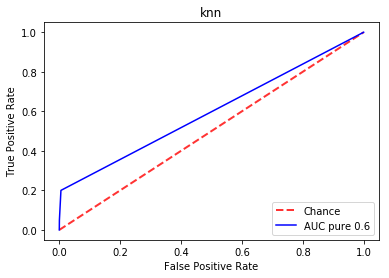

KNN Classifier
SMOTE
10 fold cross-validations TP: 104
10 fold cross-validations FP: 3981
10 fold cross-validations FN: 241
10 fold cross-validations TN: 232372


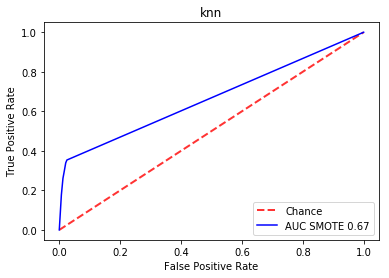

In [21]:
classification('pure', 'knn')
classification('SMOTE', 'knn')

Random Forest Classifier
Wihtout data augmentation
10 fold cross-validations TP: 25
10 fold cross-validations FP: 3
10 fold cross-validations FN: 320
10 fold cross-validations TN: 236350


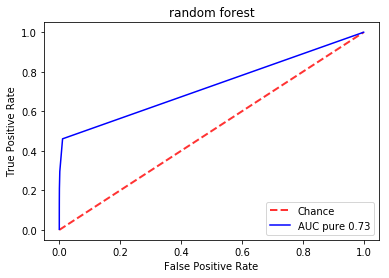

Random Forest Classifier
SMOTE
10 fold cross-validations TP: 56
10 fold cross-validations FP: 124
10 fold cross-validations FN: 289
10 fold cross-validations TN: 236229


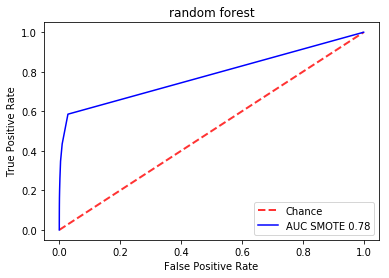

In [22]:
classification('pure', 'random forest')
classification('SMOTE', 'random forest')

AdaBoost Classifier
Wihtout data augmentation
10 fold cross-validations TP: 2
10 fold cross-validations FP: 0
10 fold cross-validations FN: 343
10 fold cross-validations TN: 236353


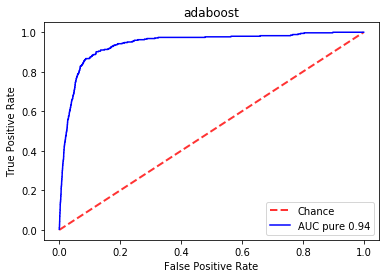

AdaBoost Classifier
SMOTE
10 fold cross-validations TP: 211
10 fold cross-validations FP: 10665
10 fold cross-validations FN: 134
10 fold cross-validations TN: 225688


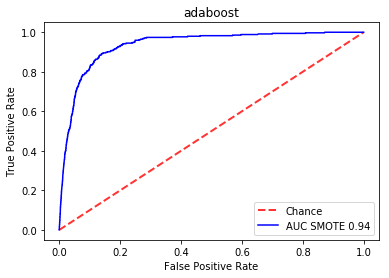

In [23]:
classification('pure', 'adaboost')
classification('SMOTE', 'adaboost')

Decision Tree Classifier
Wihtout data augmentation
10 fold cross-validations TP: 67
10 fold cross-validations FP: 337
10 fold cross-validations FN: 278
10 fold cross-validations TN: 236016


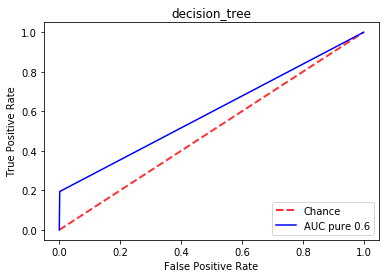

Decision Tree Classifier
SMOTE
10 fold cross-validations TP: 67
10 fold cross-validations FP: 766
10 fold cross-validations FN: 278
10 fold cross-validations TN: 235587


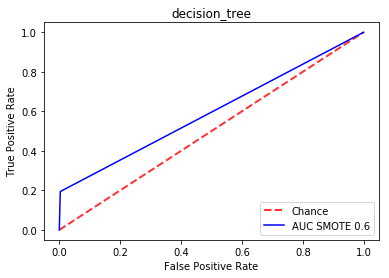

In [24]:
classification('pure', 'decision_tree')
classification('SMOTE', 'decision_tree')

Decision Tree Classifier
SMOTE
10 fold cross-validations TP: 65
10 fold cross-validations FP: 680
10 fold cross-validations FN: 280
10 fold cross-validations TN: 235673


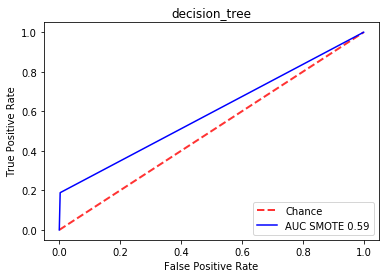

In [9]:
classification('SMOTE', 'decision_tree')